In [1]:
using Flux
using DataFrames
using CSV
using Plots
using StatsBase
using Random
using LSHFunctions
using Metrics
using JLD2, FileIO
using Statistics
using StatsPlots
using BSON: @save
using BSON: @load

# Training

In [2]:
# dims of X1 = data_x1 * data_y (INPUT)
# dims of X2 = data_x2 * data_y (OUTPUT)
# data_y = number of transactions in 1 input element

data_x1 = 60
data_x2 = 80
data_y = 480

480

In [3]:
# this function creates elements that has data_y number of transactions

function Make_Dataset(path)
  df = DataFrame(CSV.File(path))
  df = Matrix(df)
  X = []
  for i in 1:Int64(floor(size(df,1)/data_y))
    index = (i-1) * data_y + 1
    x = df[index,:]
    for j in index+1:(index + data_y -1)
        x = hcat(x,df[j,:])
        #if (mod(j,40)==0)
        #    println(j)
        #end
    end
    push!(X,x)
  end
  return X
end

Make_Dataset (generic function with 1 method)

In [4]:
# loading input features

path = "q2_emb_partial.csv"
X1 = Make_Dataset(path)

#Loading complete embeddings

path = "q2_emb_all.csv"
X2 = Make_Dataset(path)

5777-element Vector{Any}:
 [-0.31281068218995045 -0.31281068218995045 … -0.04691837424920714 -0.04691837424920714; -0.23000785455143413 -0.23000785455143413 … 0.17649474070126467 0.17649474070126467; … ; -0.6527862482333614 0.11582915101983195 … 0.30899724275149576 0.05051076836841798; -0.019330891284031003 -0.031811216085337664 … -0.16256293208322958 0.032938351845206174]
 [-0.04691837424920714 -0.04691837424920714 … -0.23207844003235317 -0.23207844003235317; 0.17649474070126467 0.17649474070126467 … -0.2259417156381739 -0.2259417156381739; … ; 0.14972933577224387 0.10085035936454356 … -0.31181367241034036 -0.17284824094658924; -0.09202292281729713 -0.05655894607673268 … 0.1059908642403517 -0.5489340477834892]
 [-0.23207844003235317 -0.23207844003235317 … -0.01638463960477678 -0.01638463960477678; -0.2259417156381739 -0.2259417156381739 … 0.31685938734388974 0.31685938734388974; … ; -1.4765645513576675 -0.3875047417024702 … -0.2591490876687428 -0.581709933479441; -0.027643302080551165

In [5]:
#Initializations

lr1 = 0.001   # for Discriminator Loss and Decoder Loss
lr2 = 0.001   # for Contextual Loss
opt1 = RMSProp(lr1 , 0.95)
opt2 = RMSProp(lr2 , 0.95)
batch_size = 4 
train_data_size = length(X1)
num_epochs = 800
num_batches = Int64(floor(train_data_size/batch_size))

1444

In [6]:
#Input 60*480 , Output 40*10

function Encoder()
return Chain(LSTM(data_x1,data_x1),
                Dense(data_x1,10),
                x -> transpose(x),
              Dense(data_y,40)
              )
end

Encoder (generic function with 1 method)

In [7]:
#Input 40*20 , Output 60*480

function Decoder()
return Chain(Dense(40,data_y),
            x -> transpose(x),
            Dense(20,data_x2)
              )
end

Decoder (generic function with 1 method)

In [8]:
#Input 60*480 , Output 1*1

function Discriminator()
return Chain(
              Dense(data_x2,1),
              #Dense(10,1),
                x -> transpose(x),
              Dense(data_y,1),
                #x ->sigmoid.(x)
              )
end

Discriminator (generic function with 1 method)

In [9]:
# x = one complete feature element
# y = label for real/fake(1/0)
# dis = Discriminator model

Loss_Dis(x,y,dis) =  sum(Flux.Losses.logitbinarycrossentropy(dis(x), y))

Loss_Dis (generic function with 1 method)

In [10]:
# z = output of encoder concatenated with noise
# decoder = Decoder model
# dis = Discriminator model

Loss_Decoder(z,decoder,dis) = sum(Flux.Losses.logitbinarycrossentropy(dis(decoder(z)), 1))

Loss_Decoder (generic function with 1 method)

In [11]:
# x1 = Real complete feature 
# x2 = Output from Decoder

Loss_Contextual(x1,x2) = sum(Flux.Losses.mse(x1,x2))

Loss_Contextual (generic function with 1 method)

In [12]:
# function to convert the elements of a 2D matrix from (0 to 1)Range to (-1 to 1)Range

function convert_range(X)
    maxx = findmax(X)
    minn = findmin(X)
    for i in 1:size(X,1)
        for j in 1:size(X,2)
            X[i,j] = (X[i,j] * 2) - 1
        end
    end
    return X
end

convert_range (generic function with 1 method)

In [13]:
# function to get the input elements of required batch sizes
# n = batch_size
# batch = batch number
# X = dataset from which batches will be taken

function Get_Real_X(n,batch,X)
  x1 = []
  upper = batch * n
  lower = upper - n + 1 
  for i in lower:upper
    push!(x1,X[i])
  end
  return x1
end

Get_Real_X (generic function with 1 method)

In [14]:
# function that creates input elements for Decoder by concatenating Encoder output with noise
# x1 = feature input
# encoder = Encoder model

function Get_Latent_Space(x1,encoder)
    z1 = []
    for i in 1:length(x1)
        push!(z1,hcat(encoder(convert(Array{Float32},x1[i])),convert_range(rand(40,10))))
    end
    return z1
end

Get_Latent_Space (generic function with 1 method)

In [15]:
# function that returns only feature embeddings generated from Decoder
# z1 = Deocder input
# deocder = Decoder model

function Get_Fake_X1(z1,decoder)
    x2 = []
    for i in 1:length(z1)
        a = decoder(z1[i])
        a = a[1:data_x1,:]
        push!(x2,a)
    end
    return x2
end

Get_Fake_X1 (generic function with 1 method)

In [16]:
# function that returns complete embeddings from Decoder
# z1 = Deocder input
# deocder = Decoder model

function Get_Fake_X2(z1,decoder)
    x2 = []
    for i in 1:length(z1)
        push!(x2,decoder(z1[i]))
    end
    return x2
end

Get_Fake_X2 (generic function with 1 method)

In [17]:
# function to update params of Discriminator
# data = Discriminator input (Complete feature embedding) with real/fake labels
# dis = Discriminator model
# flag = variable to decide whether details to be displayed

function Update_Dis!(data,dis,flag)
local l
for d in data
  gs = gradient(Flux.params(dis)) do
            l = Loss_Dis(d...,dis)
            return l
        end
  Flux.update!(opt1, Flux.params(dis), gs)
end
if(flag == 1)
  print(" Loss_Dis=",l)
end
end

Update_Dis! (generic function with 1 method)

In [18]:
# function to train the Discriminator model
# dis = Discriminator model
# encoder = Encoder model
# decoder = Decoder model
# batch = Batch number
# flag = variable to decide whether details to be displayed

function Train_Dis!(dis,encoder,decoder,batch,flag)
real = Get_Real_X(Int64(batch_size/2),batch,X2)
x1 = Get_Real_X(Int64(batch_size/2),batch,X1)
z1 = Get_Latent_Space(x1,encoder)
fake = Get_Fake_X2(z1,decoder)
#x = vcat(real,fake)
#y = vcat(ones(Int64(batch_size/2)),zeros(Int64(batch_size/2)))
x = vcat(fake,real)
y = vcat(zeros(Int64(batch_size/2)),ones(Int64(batch_size/2)))
data = zip(x,y)
Update_Dis!(data,dis,flag)
end

Train_Dis! (generic function with 1 method)

In [19]:
# function to update params of Encoder and Decoder by Decoder Loss
# data1 = input for Decoder
# dis = Discriminator model
# encoder = Encoder model
# decoder = Decoder model
# flag = variable to decide whether details to be displayed

function Update_Gen1!(data1,encoder,decoder,dis,flag)
local l1
  for d in data1
    gs1 = gradient(Flux.params(decoder)) do
            l1 = Loss_Decoder(d,decoder,dis)
            return l1
        end
    Flux.update!(opt1, Flux.params(decoder), gs1)
    gs6 = gradient(Flux.params(encoder)) do
            l1 = Loss_Decoder(d,decoder,dis)
            return l1
        end
    Flux.update!(opt1, Flux.params(encoder), gs6)
  end
  
  if(flag == 1)
    print(" Loss_Decoder=",l1)
    #print(" Loss_Contextual=",l2)
  end
end

Update_Gen1! (generic function with 1 method)

In [20]:
# function to train the Encoder and Decoder by Deocder_loss
# dis = Discriminator model
# encoder = Encoder model
# decoder = Decoder model
# batch = Batch number
# flag = variable to decide whether details to be displayed

function Train_Gen1!(encoder,decoder,dis,batch,flag)
x1 = Get_Real_X(batch_size,batch,X1)
z1 = Get_Latent_Space(x1,encoder)
data1 = z1
Update_Gen1!(data1,encoder,decoder,dis,flag)
end

Train_Gen1! (generic function with 1 method)

In [21]:
# function to update params of encoder and decoder by Contextual loss
# data2 = input for Contextual Loss
# Rest inputs same as Update_Gen1!()

function Update_Gen2!(data2,encoder,decoder,dis,flag)
local l1,l2
  
  
  for d in data2
    gs2 = gradient(Flux.params(decoder)) do
            l2 = Loss_Contextual(d...)
            return l2
        end
    Flux.update!(opt2, Flux.params(decoder), gs2)
    gs4 = gradient(Flux.params(encoder)) do
            l2 = Loss_Contextual(d...)
            return l2
        end
    Flux.update!(opt2, Flux.params(encoder), gs4)
  end
  
  if(flag == 1)
    print(" Loss_Contextual=",l2)
  end
end

Update_Gen2! (generic function with 1 method)

In [22]:
# function to train the Encoder and Decoder based on Contextual Loss
# inputs same as Train_Gen1!

function Train_Gen2!(encoder,decoder,dis,batch,flag)
x1 = Get_Real_X(batch_size,batch,X1)
z1 = Get_Latent_Space(x1,encoder)
x2 = Get_Fake_X1(z1,decoder)
#data1 = z1
data2 = zip(x1,x2)
Update_Gen2!(data2,encoder,decoder,dis,flag)
end

Train_Gen2! (generic function with 1 method)

In [23]:
# function to train the complete model for all batches in 1 epoch
# dis = Discriminator model
# encoder = Encoder model
# decoder = Decoder model

function Train_GAN!(dis,encoder,decoder)
    for batch in 1:num_batches
      if (mod(batch,1000)==0)
        print(" Batch:",batch)
        flag = 1
      else
        flag = 0
      end
      Train_Gen1!(encoder,decoder,dis,batch,flag)
      Train_Dis!(dis,encoder,decoder,batch,flag)
      Train_Gen2!(encoder,decoder,dis,batch,flag)
      if (flag==1)
      println()
      end
    end
  #end
end

Train_GAN! (generic function with 1 method)

In [24]:
# Execute training for given number of epochs
# Takes around 6 hrs for a quarter year of data
dis = Discriminator()
encoder = Encoder()
decoder = Decoder()
#num_epochs = 10
Threads.@threads for epoch in 1:num_epochs
    #if( epoch <= 500 && mod(epoch,35)==0 )
    #    lr1 = lr1 * 0.9
    #    opt1 = RMSProp(lr1 , 0.95) 
    #end
    println("###########################  Epoch : ",epoch,"  #########################")
    Train_GAN!(dis,encoder,decoder)
    if(mod(epoch,10)==0)
        dis_weights = Flux.params(dis);
        dec_weights = Flux.params(decoder);
        enc_weights = Flux.params(encoder);
        @save "dis_weights.bson" dis_weights
        @save "decoder_weights.bson" dec_weights
        @save "encoder_weights.bson" enc_weights
    end
    println()
end

###########################  Epoch : 201  #########################
###########################  Epoch : 301  #########################
###########################  Epoch : 751  #########################
###########################  Epoch : 701  #########################
###########################  Epoch : 451  #########################
###########################  Epoch : 51  #########################
###########################  Epoch : 401  #########################
###########################  Epoch : 151  #########################
###########################  Epoch : 501  #########################
###########################  Epoch : 351  #########################
###########################  Epoch : 1  #########################
###########################  Epoch : 251  #########################
###########################  Epoch : 601  #########################
###########################  Epoch : 101  #########################
###########################  Epoch : 551  #########

# Generating Results

In [25]:
# function to create test data from the the training data itself
# X1 = only features embedding data
# X2 = complete embedding data

function get_test_data(X1,X2)
    test_x1 = []
    test_x2 = []
    test_index = []
    i = 1
    while(i<length(X1))
        push!(test_x1,X1[i])
        push!(test_x2,X2[i])
        index = (i-1) * data_y + 1
        for j in index:(index + data_y - 1)
            push!(test_index,j)
        end
        i = i + 1000
    end
    return test_x1,test_x2,test_index
end

get_test_data (generic function with 1 method)

In [26]:
# function that generates the output form Decoder
# X = input for encoder

function get_generated_data(X)
    gen_data = []
    for i in 1:length(X)
        push!(gen_data,decoder(hcat(encoder(convert(Array{Float32},X[i])),convert_range(rand(40,10)))))
    end
    return gen_data
end

get_generated_data (generic function with 1 method)

In [35]:
dict_beg = load("q2_dict_beg.jld2")["q2_dict_beg"]    #stores starting index of each Segment Cluster
dict_end = load("q2_dict_end.jld2")["q2_dict_end"]    #stores ending index of each Segment Cluster

Dict{Any, Any} with 19 entries:
  "Lunch_Weekend4"     => 1720406
  "Lunch_Weekday3"     => 1133390
  "Lunch_Weekday2"     => 1081979
  "Dinner_Weekend1"    => 2678453
  "Breakfast_Weekday2" => 306854
  "Lunch_Weekday4"     => 1214340
  "Dinner_Weekday2"    => 2386092
  "Dinner_Weekday3"    => 2457126
  "Dinner_Weekday1"    => 2154669
  "Dinner_Weekend2"    => 2740837
  "Lunch_Weekday5"     => 1322756
  "Lunch_Weekday1"     => 681542
  "Lunch_Weekend3"     => 1716524
  "Lunch_Weekend2"     => 1660140
  "Lunch_Weekend1"     => 1412675
  "Breakfast_Weekday1" => 183856
  "Breakfast_Weekend1" => 465498
  "Lunch_Weekday6"     => 1331272
  "Dinner_Weekend3"    => 2773317

In [28]:
# function that finds the most similar transaction key
# X = Decoder output
# emb = Complete transaction details data
# test_index = indices of transaction details of input test data

function get_index(X,emb,test_index)
    data = []
    for i in 1:length(X)
        for j in 1:data_y
            push!(data,X[i][:,j])
        end
    end
    

    index = []
    sum = 0
    for i in 1:length(data)
        lower = dict_beg[df.seg[test_index[i]]]
        upper = dict_end[df.seg[test_index[i]]]
        maxx = cossim(emb[lower,:],data[i])
        ind = lower
        for j in lower+1 : upper
            val = cossim(emb[j,:],data[i])
            if(val>maxx)
                maxx = val
                ind = j
            end
        end
        sum = sum + maxx
        push!(index,ind)
        println(i)
    end
        
        
    println("Average Similarity : ",sum/length(data))
    return index
end

get_index (generic function with 1 method)

In [29]:
# function that finds the Sales division
# sales = Sales amount of that transaction

function get_sales_div(sales)
    sales_div = ["Sales_0-3","Sales_3-6","Sales_6-8","Sales_8-11","Sales_11-18","Sales_18-22","Sales_22-50"]
    if(sales >=0.0 && sales<=3.0)
        return sales_div[1]
    elseif(sales >3.0 && sales <=6.0)
        return sales_div[2]
    elseif(sales >6.0 && sales <=8.0)
        return sales_div[3]
    elseif(sales >8.0 && sales <=11.0)
        return sales_div[4]        
    elseif(sales >11.0 && sales <=18.0)
        return sales_div[5]
    elseif(sales >18.0 && sales <=22.0)
        return sales_div[6]
    else
        return sales_div[7]
    end
end

get_sales_div (generic function with 1 method)

In [30]:
# function that calculates and compares the Sales_Amount Details between Test data and Generated Data

function total_sales(test_index,gen_index)
    dict = Dict{String,Integer}("Sales_0-3" => 1,
                                "Sales_3-6" => 2,
                                "Sales_6-8" => 3,
                                "Sales_8-11" => 4,
                                "Sales_11-18" => 5,
                                "Sales_18-22" => 6,
                                "Sales_22-50" => 7)
    x1 = zeros(7)
    x2 = zeros(7)
    sales_div = ["Sales_0-3","Sales_3-6","Sales_6-8","Sales_8-11","Sales_11-18","Sales_18-22","Sales_22-50"]
    test_sales = 0
    gen_sales = 0
    for i in 1:length(test_index)
        test_sales = test_sales + df.sales[test_index[i]]
        gen_sales = gen_sales + df.sales[gen_index[i]]
        #x1[dict[get_sales_div(df.sales[test_index[i]])]] += 1
        #x2[dict[get_sales_div(df.sales[gen_index[i]])]] += 1
        x1[dict[get_sales_div(df.sales[test_index[i]])]] += df.sales[test_index[i]]
        x2[dict[get_sales_div(df.sales[gen_index[i]])]] += df.sales[gen_index[i]]
    end
    df1 = DataFrame(Sales_Division = sales_div , Test_Data = x1 , Gen_Data = x2)
    println("Total Test_Data Sales : ",test_sales)
    println("Total Gen_Data Sales : ",gen_sales)
    println("Difference between Test and Generated Sales : ",(test_sales - gen_sales))
    println("Percentage Difference : ",((abs(test_sales - gen_sales))/test_sales)*100 , " %")
    #println(df1)
    return test_sales,gen_sales,df1
end

total_sales (generic function with 1 method)

In [31]:
using Word2Vec
model = wordvectors("text_store_sales_channel-vec.txt")
words = vocabulary(model)
channels = words[16:33]

18-element Vector{String}:
 "EatIn(EI)"
 "TakeAway(TA)"
 "Drive-Thru"
 "FoodpandaDaypart"
 "DeliverooDaypart"
 "Breakfast(BF)"
 "Self-OrderingEI"
 "Self-OrderingTA"
 "Online-Delivery"
 "Phone-Delivery"
 "Phone-Pickup"
 "GrabfoodDaypart"
 "FoodpandaBreakfast"
 "GrabfoodBreakfast"
 "Catering"
 "DeliverooBreakfast"
 "Birthday/KidsTour"
 "Online-Pickup"

In [32]:
function remove_space(s)
    s1 = ""
    for i in 1:length(s)
        if(!isspace(s[i]))
            s1 = s1 * s[i]
        end
    end
    return s1
end

remove_space (generic function with 1 method)

In [33]:
# function that calculates and compares the Sales_Channel Details between Test data and Generated Data

function channel_compare(test_index,gen_index)
    dict = Dict()
    for i in 1:length(channels)
        dict[channels[i]] = i
    end
    x1 = zeros(length(channels))
    x2 = zeros(length(channels))
    for i in 1:length(test_index)
        x1[dict[remove_space(df.sales_channel[test_index[i]])]] += 1
        x2[dict[remove_space(df.sales_channel[gen_index[i]])]] += 1
    end
    df1 = DataFrame(Sales_Channel = channels , Test_Data = x1 , Gen_Data = x2)
    #println(df1)
    return df1
end

channel_compare (generic function with 1 method)

In [34]:
# emb = Complete transaction details data
# df = Complete embeddings data
# Transaction sequence in both the datasets is same

emb = Matrix(DataFrame(CSV.File("q2_emb_all.csv")))
df = DataFrame(CSV.File("q2_embedding_Cluster.csv"))

,store_transaction_key,sales_channel,x1,x2,x3,x4
,String,String,Float64,Float64,Float64,Float64
1,502_6425_2020-05-01,Eat In (EI),-0.850979,-0.171626,0.142831,-0.668974
2,502_6431_2020-04-30,Self-Ordering TA,0.368524,-0.197703,-0.175374,0.254341
3,502_6435_2020-04-30,Self-Ordering TA,-0.888011,-0.1887,0.206953,-0.556971
4,502_6436_2020-04-30,Self-Ordering TA,-0.472576,0.207012,-0.195561,-0.715953
5,502_6437_2020-04-30,Self-Ordering TA,-0.66636,0.411038,-0.116234,-0.446571
6,502_6438_2020-04-30,Self-Ordering TA,-1.77183,-0.0980636,0.23183,-0.300761
7,502_6439_2020-04-30,Self-Ordering TA,-0.278246,-0.366809,0.843756,-0.54607
8,502_6440_2020-04-30,Self-Ordering TA,-1.79514,0.737257,-0.323361,-0.924448
9,502_6441_2020-04-30,Self-Ordering TA,-0.184976,-0.260535,0.789594,-0.928831


In [36]:
# test_x1 = input for encoder(feature embeddings)
# test_x2 = complete embeddings
# test_index = indices of the test_data transactions

test_x1,test_x2,test_index = get_test_data(X1,X2)

(Any[[-0.31281068218995045 -0.31281068218995045 … -0.04691837424920714 -0.04691837424920714; -0.23000785455143413 -0.23000785455143413 … 0.17649474070126467 0.17649474070126467; … ; 0.32313320156619624 0.1689573722320272 … -0.24065620624346765 -0.3476489079607606; -0.2823574759689006 -0.0733059861583558 … 0.23388400181513863 0.3242617368151092], [-0.31281068218995045 -0.31281068218995045 … -0.04691837424920714 -0.04691837424920714; -0.23000785455143413 -0.23000785455143413 … 0.17649474070126467 0.17649474070126467; … ; 0.3200607100821405 0.3200607100821405 … 0.3200607100821405 0.3200607100821405; -0.13725458353070283 -0.13725458353070283 … -0.13725458353070283 -0.13725458353070283], [-0.31281068218995045 -0.31281068218995045 … -0.31281068218995045 -0.31281068218995045; -0.23000785455143413 -0.23000785455143413 … -0.23000785455143413 -0.23000785455143413; … ; 0.3200607100821405 0.3200607100821405 … 0.3200607100821405 0.3200607100821405; -0.13725458353070283 -0.13725458353070283 … -0.137

In [55]:
# gen_data = Deocder output
gen_data = get_generated_data(test_x1)

6-element Vector{Any}:
 [0.5004009428106959 0.06522422625918389 … 1.1230881851280459 1.1022824455266715; -0.09208229285841775 0.019671253516998666 … -0.1544476433825543 0.08385892203880033; … ; 0.05481705170320056 -0.31492399960237133 … 0.4536118040818262 1.1456918850426965; -0.2650708594777542 0.6647701611509349 … 0.9630371173926968 1.1924971278021392]
 [-0.05868315893323789 0.6945008347753234 … -0.29011195900107656 0.32027958188055444; -0.1939615210194972 0.20023449393443238 … 0.28090541606004643 -0.11001955578411718; … ; -1.7668943096208662 -0.04698755165225832 … 0.18365932517050565 0.7355304375485041; -0.6542694925401598 1.0474487872373335 … -0.6104499113562369 1.326349531366639]
 [0.3438397277914572 0.07849887646516485 … -0.42089212382470187 0.27293028819284937; 0.08904274619222699 0.215633264564824 … 0.11842285067763576 0.18252384944299394; … ; -0.05382335170822844 -0.2622788766229985 … -0.017744795337428065 -0.15080750584056307; 0.6057116289148848 1.151645226978274 … -0.01068722

In [53]:
# saving gen_data
save("gen_data_2.jld2", "gen_data", gen_data)

In [54]:
# loading the gen_data
#load("gen_data_2.jld2")["gen_data"]

6-element Vector{Any}:
 [1.314656847788802 -0.634121889265334 … -0.23320236328418098 0.14395227708954317; -0.40503832368339815 0.47746627868716096 … 0.19660947472219578 -0.09430685656494309; … ; 0.11932006929944217 2.0698030065243156 … 0.6217872424208826 0.6221508253796943; 0.023596001401821665 0.35408940000124023 … 0.3055021143168507 0.7767349268250612]
 [1.0556258999137746 1.4561505924043996 … 0.8663857184979291 0.26949291607469683; -0.4369708665326192 -0.14088405655580388 … -0.08783532509080653 0.38223241996162366; … ; -0.4532437433866342 0.8586979407963768 … 0.0645971008359722 0.07962063222538668; 0.934047099864524 0.8265731821369862 … 0.46274183677097747 -0.6307462380178448]
 [-0.10536076965009206 0.4775209451541471 … 1.0099566525520893 0.5949642660449042; 0.3923504546440977 0.045670652684295904 … 0.24915355209111983 -0.004914934149661668; … ; -1.4116556624465493 0.14213953638223853 … -0.02761677809916996 0.3043348136707791; -0.8393692402979304 0.9927820447581848 … -0.563842775925

In [38]:
# gen_index = getting indices of generated data
# Takes around 20 mins to execute
gen_index = get_index(gen_data,emb,test_index)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


2880-element Vector{Any}:
   31816
  127960
  182562
   16566
  101300
   79264
  173825
   23311
  182426
   40275
   95337
   38132
   40967
       ⋮
 2433667
 2406661
 2397974
 2424630
 2406123
 2444817
 2441904
 2443345
 2406556
 2392460
 2400129
 2388854

In [39]:
# test_sales = total test data sales
# gen_sales = total gen data sales
# df_sales = dataframe with sales amount details by each division

test_sales,gen_sales,df_sales = total_sales(test_index,gen_index)

Total Test_Data Sales : 53427.60159999999
Total Gen_Data Sales : 59319.00049999993
Difference between Test and Generated Sales : -5891.398899999942
Percentage Difference : 11.026882591712564 %


(53427.60159999999, 59319.00049999993, 7×3 DataFrame
│ Row │ Sales_Division │ Test_Data │ Gen_Data │
│     │ String         │ Float64   │ Float64  │
├─────┼────────────────┼───────────┼──────────┤
│ 1   │ Sales_0-3      │ 115.888   │ 31.5418  │
│ 2   │ Sales_3-6      │ 1143.09   │ 608.134  │
│ 3   │ Sales_6-8      │ 1960.01   │ 1934.58  │
│ 4   │ Sales_8-11     │ 4673.18   │ 2493.61  │
│ 5   │ Sales_11-18    │ 7740.1    │ 13790.2  │
│ 6   │ Sales_18-22    │ 6350.19   │ 2674.3   │
│ 7   │ Sales_22-50    │ 31445.1   │ 37786.6  │)

In [40]:
# df_channels = dataframe with sales channel frequency by each channel
df_channels = channel_compare(test_index,gen_index)

,Sales_Channel,Test_Data,Gen_Data
,String,Float64,Float64
1,EatIn(EI),110.0,258.0
2,TakeAway(TA),1021.0,1358.0
3,Drive-Thru,44.0,108.0
4,FoodpandaDaypart,125.0,228.0
5,DeliverooDaypart,12.0,11.0
6,Breakfast(BF),7.0,15.0
7,Self-OrderingEI,47.0,100.0
8,Self-OrderingTA,588.0,240.0
9,Online-Delivery,580.0,100.0


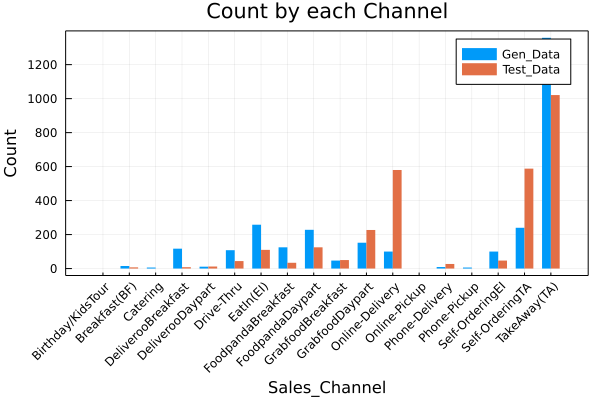

In [42]:
# Plotting df_channels

ctg = repeat(["Test_Data", "Gen_Data"], inner = 18)
nam = repeat(df_channels.Sales_Channel, outer = 2)

groupedbar(nam, hcat(df_channels.Test_Data,df_channels.Gen_Data), group = ctg, xlabel = "Sales_Channel", ylabel = "Count",
        title = "Count by each Channel", bar_width = 0.67,xrotation = 45,
        lw = 0, framestyle = :box)

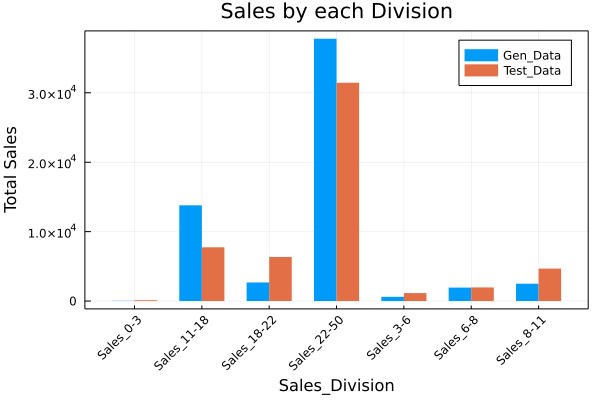

In [43]:
# Plotting df_sales

ctg = repeat(["Test_Data", "Gen_Data"], inner = 7)
nam = repeat(df_sales.Sales_Division, outer = 2)

groupedbar(nam, hcat(df_sales.Test_Data,df_sales.Gen_Data), group = ctg, xlabel = "Sales_Division", ylabel = "Total Sales",
        title = "Sales by each Division", bar_width = 0.67,xrotation = 45,
        lw = 0, framestyle = :box)